In [3]:
import pandas
import numpy
import matplotlib.pyplot as plt
import gurobipy
from MSP.MSLP import MSLP
from MSP.solver import SDDP
from MSP.evaluation import EvaluationTrue
hydro_ = pandas.read_csv("./data/hydro.csv", index_col = 0)
thermal_ = [pandas.read_csv("./data/thermal_{}.csv".format(i), index_col = 0) for i in range(4)]
demand = pandas.read_csv("./daademand.csv", index_col = 0)
deficit_ = pandas.read_csv(path + "deficit.csv", index_col = 0)
exchange_ = pandas.read_csv(path + "exchange.csv", index_col = 0)
T = 120
numpy.random.seed(0)

FileNotFoundError: File b'example/hydro_thermal/hydro.csv' does not exist

In [2]:
hist = pandas.read_csv("example/hydro_thermal/hist_0.csv", sep = ";")

In [3]:
train = hist[hist['YEAR']<=2012]
test = hist[hist['YEAR']>=2013]

In [4]:
train = train.drop(columns = 'YEAR')
test = test.drop(columns = 'YEAR')

In [5]:
train.head()

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,56896.80,86488.31,88646.94,64581.71,43078.74,32150.18,25738.04,20606.05,22772.16,23767.55,25831.89,38566.50
1,56451.95,61922.34,50742.10,35954.27,27000.91,25285.24,19913.20,16801.72,15034.40,22347.14,25004.76,48755.60
2,65408.16,51128.33,40424.25,34627.46,24456.72,19099.70,16790.67,14192.07,13741.74,17339.43,18503.66,36070.84
3,46580.39,37113.35,35392.72,27179.93,19080.88,14173.57,11860.90,9904.96,11835.56,12925.78,13594.84,33700.23
4,54645.97,72711.15,61323.17,54644.39,34731.77,26184.86,19927.38,19833.32,18289.43,34902.46,26176.69,32033.65


The histogram of inflow data $X_t$ shows negative skewness. Hence we first make a logrithm on the data.

(array([234., 305., 163., 112.,  97.,  44.,  16.,  11.,   1.,   1.]),
 array([  9500.66 ,  20404.863,  31309.066,  42213.269,  53117.472,
         64021.675,  74925.878,  85830.081,  96734.284, 107638.487,
        118542.69 ]),
 <a list of 10 Patch objects>)

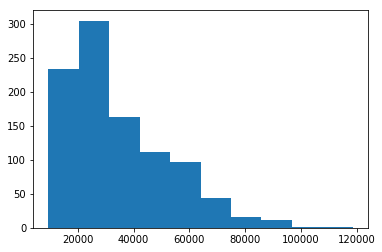

In [6]:
plt.hist(train.values.flatten())

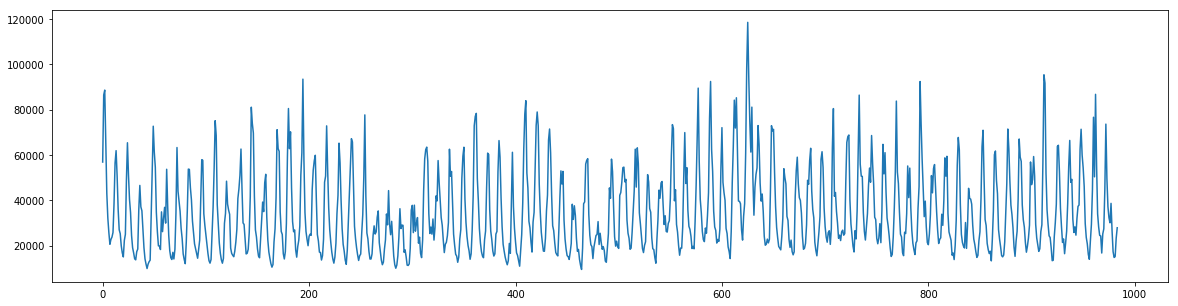

In [7]:
plt.figure(figsize= [20,5])
plt.plot(train.values.flatten())

In [8]:
train = numpy.log(train)

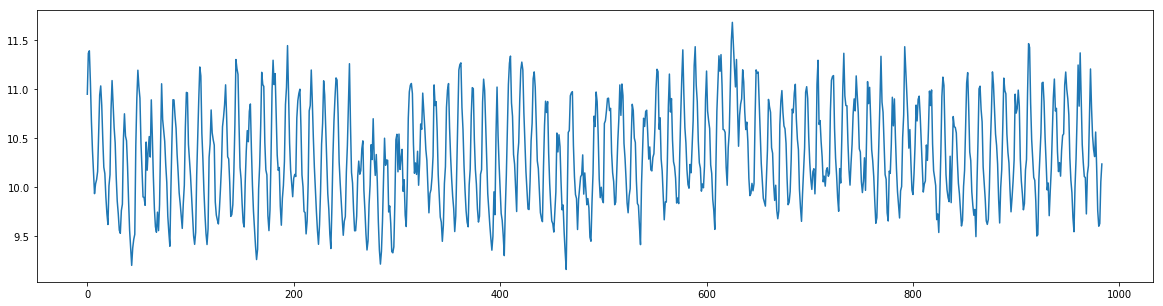

In [9]:
plt.figure(figsize= [20,5])
plt.plot(train.values.flatten())

Remove seasonality by subtracting monthly mean and replace missing data with monthly mean

In [10]:
mean = train.mean()

In [11]:
for i in range(12):
    train.iloc[:,i].fillna(mean[i], inplace = True)

In [12]:
mean_total = pandas.concat([pandas.DataFrame(mean).transpose()]*len(train))

In [13]:
mean_total.reset_index(drop = True, inplace = True)

In [14]:
train -= mean_total

In [15]:
train = train.values.flatten()

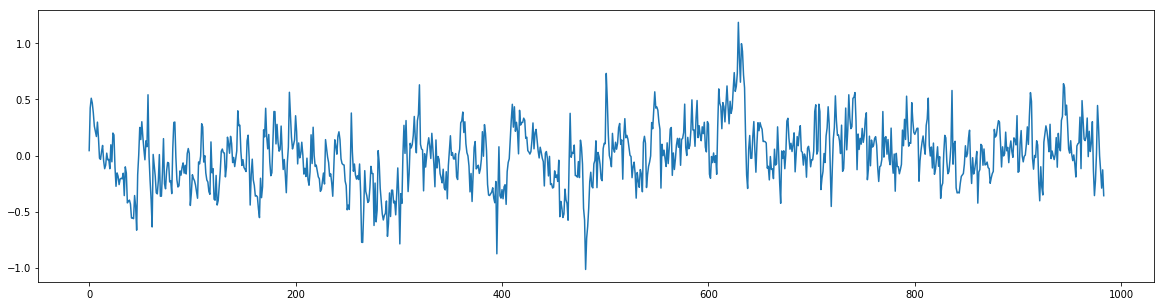

In [16]:
plt.figure(figsize= [20,5])
plt.plot(train)

Augmented Dickey-Fuller Stationary Test shows the serial data is stationary

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
print("p Value: ", adfuller(train)[1])

p Value:  7.366005366493816e-12


Partial autocorrelation function plot has one spike at lag one. This is a strong evidence of first order Auto Regressive Model AR(1):

\begin{equation*}
Z_t = \phi Z_{t-1} + a_t
\end{equation*}

Where $a_t\sim N(0,\sigma_a^2)$, $Z_t = \log(X_t)-\mu_t$

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

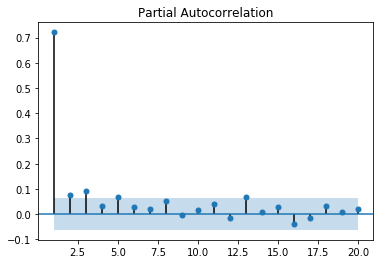

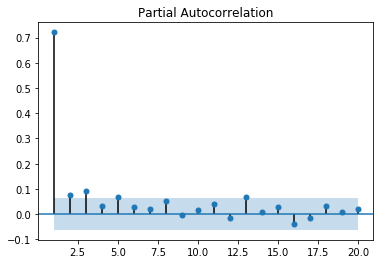

In [20]:
plot_pacf(train, lags = 20, alpha = 0.05, zero = False)

In [21]:
len(train)

984

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

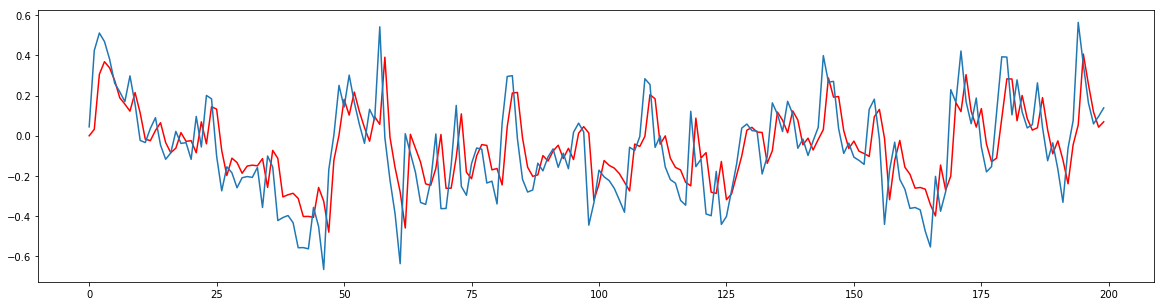

In [22]:
from statsmodels.tsa.arima_model import ARIMA
result = ARIMA(train, order = (1,0,0)).fit(maxlag = 1, trend = 'nc')
phi = result.params[0]
sigma = numpy.std(train) * numpy.sqrt(1-phi**2)
plt.figure(figsize= [20,5])
plt.plot(result.fittedvalues[0:200],color = 'red')
plt.plot(train[0:200])

Now we can do similar analysis on the other three reserviors


In [23]:
phi = [None for i in range(4)]
sigma = [None for i in range(4)]
mean = [None for i in range(4)]

for i in range(4):
    hist = pandas.read_csv("example/hydro_thermal/hist_{}.csv".format(i), sep = ";")
    train = hist[hist['YEAR']<=2012]
    train = train.drop(columns = 'YEAR')
    train = numpy.log(train)
    mean_ = train.mean()
    for k in range(12):
        train.iloc[:,k].fillna(mean_[k], inplace = True)
    mean_total = pandas.concat([pandas.DataFrame(mean_).transpose()]*len(train))
    mean_total = mean_total.reset_index(drop = True)
    train -= mean_total
    train = train.values.flatten()
    result = ARIMA(train, order = (1,0,0)).fit(maxlag = 1, trend = 'nc')
    phi[i] = result.params[0]
    sigma[i] = numpy.std(train) * numpy.sqrt(1-phi[i]**2)
    mean[i] = mean_.values

Transfer back from $Z_t$ to $X_t$, we get $X_t = X_{t-1}^\phi \exp(a_t + \mu_t - \phi \mu_{t-1})$. We can then set up a sample path generator as follows.

In [25]:
path = "example/hydro_thermal/"
hydro_ = pandas.read_csv(path + "hydro.csv", index_col = 0)
def inflow_sampler():
    initial = [list(hydro_['INITIAL'][4:8].values)]
    for t in range(T-1):
        temp = [None for _ in range(4)]
        for k in range(4):
            noise = numpy.random.normal(0, sigma[k])
            temp[k] = initial[-1][k] ** phi[k] * numpy.exp(noise + mean[k][t%12] - mean[k][(t-1)%12])
        initial.append(temp) 
    return initial

In [27]:
import src.MarkovChainDiscretization as MarkovChainDiscretization
stateSpace, transitionMatrix = MarkovChainDiscretization.MarkovChainDiscretization_gradient(inflow_sampler, [1] + [10]*(T-1), 0.1,0.1)

Here we create an MSLP instance with an additional argument memory_enlarge to avoid running-out-of-memory issue. 

In [28]:
HydroThermal = SDDP.MSLP(T = T, bound = 0, memory_enlarge = 1)
HydroThermal.setMCUncertainty(stateSpace, transitionMatrix)
for t in range(T):
    m = HydroThermal.models[t]
    stored_now, stored_past = m.addStateVars(4, ub = hydro_['UB'][:4], name = "stored")
    spill = m.addVars(4, name = "spill")
    hydro = m.addVars(4, ub = hydro_['UB'][-4:], name = "hydro")
    deficit = m.addVars([(i,j) for i in range(4) for j in range(4)], ub = [demand.iloc[t%12][i] * deficit_['DEPTH'][j]  for i in range(4) for j in range(4)], 
                         obj = [deficit_['OBJ'][j] for i in range(4) for j in range(4)], name = "deficit")
    thermal = [None] * 4
    
    for i in range(4):
        thermal[i] = m.addVars(len(thermal_[i]), ub = thermal_[i]['UB'], lb = thermal_[i]['LB'], obj = thermal_[i]['OBJ'], name = "thermal_{}".format(i))
    
    exchange = m.addVars(5,5, ub = exchange_.values.flatten(), name = "exchange")
    
    thermal_sum = m.addVars(4, name = "thermal_sum")
    
    m.addConstrs(thermal_sum[i] == gurobipy.quicksum(thermal[i]) for i in range(4))
    
    for i in range(4): 
        m.addConstr(thermal_sum[i] + gurobipy.quicksum(deficit[(i,j)] for j in range(4)) + hydro[i] - 
                    gurobipy.quicksum(exchange[(i,j)] for j in range(5)) + 
                    gurobipy.quicksum(exchange[(j,i)] for j in range(5)) == demand.iloc[t%12][i])

    m.addConstr(gurobipy.quicksum(exchange[(j,4)] for j in range(5)) 
                - gurobipy.quicksum(exchange[(4,j)] for j in range(5)) == 0)

    for i in range(4):
        m.addConstr(stored_now[i] + spill[i] + hydro[i] - stored_past[i] == 0, 
                        uncertaintyDependent = {'rhs':i})
    
    # intial condition #
    if t == 0:
        m.addConstrs(stored_past[i] == hydro_['INITIAL'][:4][i] for i in range(4))

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [29]:
HydroThermal.SDDP()

------------------------------------------------------------------------------------
                             SDDP Solver, Lingquan Ding                             
------------------------------------------------------------------------------------
   Iteration                  LB                 UB CI                          Time
------------------------------------------------------------------------------------
           0  32516939697.080128 33104688224.265247, 33104688224.265247     0.904703
           1  32516939697.080143 32646750366.262321, 32646750366.262321     0.399745
           2  32516939697.080170 32566500519.320602, 32566500519.320602     0.398121
           3  32516939697.080170 32513961608.986160, 32513961608.986160     0.416835
           4  32516939697.080170 32517843060.535828, 32517843060.535828     0.445443
           5  32516939697.080173 32524528807.098652, 32524528807.098652     0.400419
           6  32516939697.080173 32515919075.484806, 32515919075.

KeyboardInterrupt: 